In [1]:
import numpy as np
import pandas as pd
import random
from sklearn.svm import SVC, SVR
from sklearn.metrics import accuracy_score

## Load data

In [2]:
x_train = np.load("x_train.npy")
y_train = np.load("y_train.npy")
x_test = np.load("x_test.npy")
y_test = np.load("y_test.npy")

In [3]:
# 550 data with 300 features
print(x_train.shape)

(550, 300)


In [4]:
# It's a binary classification problem 
print(np.unique(y_train))

[0 1]


## Question 1
K-fold data partition: Implement the K-fold cross-validation function. Your function should take K as an argument and return a list of lists (len(list) should equal to K), which contains K elements. Each element is a list contains two parts, the first part contains the index of all training folds, e.g. Fold 2 to Fold 5 in split 1. The second part contains the index of validation fold, e.g. Fold 1 in  split 1

In [5]:
def cross_validation(x_train, y_train, k=5):
    # Random is equivalent to shufle 
    number_all = x_train.shape[0]
    number_plus = number_all % k
    number_choose = [int(number_all/k) for i in range(k)]
    for i in range(number_plus):
        number_choose[i] += 1 
    all_ = [i for i in range(0, number_all)]
    k_partition_index = []
    for number in number_choose:
        choose = random.sample(all_, number)
        k_partition_index.append([choose])
        all_ = list(set(all_) - set(choose))

    all_ = [i for i in range(0, number_all)]
    kfold_data = []
    for i in range(k):
        val_index = k_partition_index[i][0]
        train_index = np.array(list(set(all_) - set(val_index)))
        val_index = np.array(val_index)
        kfold_data.append([train_index, val_index])
    return kfold_data

In [6]:
kfold_data = cross_validation(x_train, y_train, k=10)
assert len(kfold_data) == 10 # should contain 10 fold of data
assert len(kfold_data[0]) == 2 # each element should contain train fold and validation fold
assert kfold_data[0][1].shape[0] == 55 # The number of data in each validation fold should equal to training data divieded by K

## example

In [7]:
from sklearn.model_selection import KFold

X = np.arange(20)
kf = KFold(n_splits=5, shuffle=True)
kfold_data_example= []
for i, (train_index, val_index) in enumerate(kf.split(X)):
    print("Split: %s, Training index: %s, Validation index: %s" % (i+1, train_index, val_index))
    kfold_data_example.append([train_index, val_index])

Split: 1, Training index: [ 2  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19], Validation index: [ 0  1  3 14]
Split: 2, Training index: [ 0  1  2  3  4  5  6  7  9 10 11 13 14 15 16 19], Validation index: [ 8 12 17 18]
Split: 3, Training index: [ 0  1  2  3  6  7  8  9 10 11 12 14 15 17 18 19], Validation index: [ 4  5 13 16]
Split: 4, Training index: [ 0  1  3  4  5  7  8  9 10 11 12 13 14 16 17 18], Validation index: [ 2  6 15 19]
Split: 5, Training index: [ 0  1  2  3  4  5  6  8 12 13 14 15 16 17 18 19], Validation index: [ 7  9 10 11]


In [8]:
assert len(kfold_data_example) == 5 # should contain 5 fold of data
assert len(kfold_data_example[0]) == 2 # each element should contains index of training fold and validation fold
assert kfold_data_example[0][1].shape[0] == 4 # The number of data in each validation fold should equal to training data divieded by K

## Question 2
Using sklearn.svm.SVC to train a classifier on the provided train set and conduct the grid search of “C” and “gamma” to find the best parameters by cross-validation.

In [9]:
## your code

def Training(x_train, y_train, clf, kfold_data):
    times = len(kfold_data)
    total_accuracy = 0
    for i in range(times):
        training_index = kfold_data[i][0]
        val_index = kfold_data[i][1]
        training_data = x_train[training_index, :]
        training_label = y_train[training_index]
        val_data = x_train[val_index, :]
        val_label = y_train[val_index]
        clf.fit(training_data, training_label)
        accuracy = clf.score(val_data, val_label)
        total_accuracy += accuracy
    return total_accuracy / times

def Grid_Search(C_list, gamma_list, x_train, y_train, kfold_data, method):
    best_accuracy = 0
    best_C = 0
    best_gamma = 0
    best_model = None
    gird_array = np.zeros((len(C_list), len(gamma_list)))
    for i, gamma in enumerate(gamma_list):
        for j, C in enumerate(C_list):
            if method == "SVC":
                clf = SVC(C=C, kernel='rbf', gamma=gamma)
            else:
                clf = SVR(C=C, kernel='rbf', gamma=gamma, epsilon=0.1)
            accuracy = Training(x_train, y_train, clf, kfold_data)
            gird_array[j, i] = accuracy
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_C = C
                best_gamma = gamma
                best_model = clf
    return best_accuracy, best_C, best_gamma, gird_array, best_model

method = "SVC"
kfold_data = cross_validation(x_train, y_train, k=5)
C_list = [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]
gamma_list = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
best_accuracy, best_C, best_gamma, gird_array, best_model = Grid_Search(C_list, gamma_list, x_train, y_train, kfold_data, method)


In [10]:
print(f"best_accuracy is {best_accuracy:.03f}")
print(f"best_parameters C is {best_C}\t best_parameters gamma is {best_gamma}")

best_accuracy is 0.884
best_parameters C is 10.0	 best_parameters gamma is 0.001


## Question 3
Plot the grid search results of your SVM. The x, y represents the hyperparameters of “gamma” and “C”, respectively. And the color represents the average score of validation folds
You reults should be look like this reference image below ![image](https://miro.medium.com/max/1296/1*wGWTup9r4cVytB5MOnsjdQ.png) 

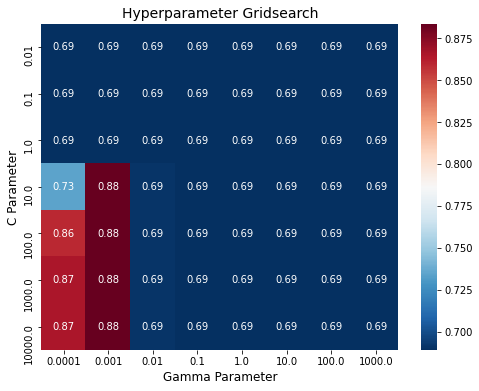

In [11]:
import seaborn as sn
import matplotlib.pyplot as plt

df = pd.DataFrame(gird_array, index=[i for i in C_list], columns=[i for i in gamma_list])
plt.figure(figsize=(8, 6))
plt.title("Hyperparameter Gridsearch", fontsize="14")
sn.heatmap(df, annot=True, cmap='RdBu_r')
plt.xlabel("Gamma Parameter", fontsize="12")
plt.ylabel("C Parameter", fontsize="12")
plt.show()

## Question 4
Train your SVM model by the best parameters you found from question 2 on the whole training set and evaluate the performance on the test set. **You accuracy should over 0.85**

In [12]:
y_pred = best_model.predict(x_test)
print(f"Accuracy score: {accuracy_score(y_pred, y_test):.04f}")

Accuracy score: 0.8906


## Question 5
Compare the performance of the model you have implemented in HW1 with the SVM

### HW1

In [13]:
train_df = pd.read_csv("../HW1/train_data.csv")
x_train = train_df['x_train'].to_numpy().reshape(-1, 1)
y_train = train_df['y_train'].to_numpy().reshape(-1, 1)

test_df = pd.read_csv("../HW1/test_data.csv")
x_test = test_df['x_test'].to_numpy().reshape(-1, 1)
y_test = test_df['y_test'].to_numpy().reshape(-1, 1)

#from HW1
w0_MSE = -0.0012762766165574284
w1_MSE = 0.452720248401306
y_pred_MSE = w0_MSE + w1_MSE*x_test
MSE_loss = np.sum((y_test-y_pred_MSE)**2) / len(x_test)

y_train = train_df['y_train'].to_numpy().reshape(-1)
y_test = test_df['y_test'].to_numpy().reshape(-1)

method = "SVR"
kfold_data = cross_validation(x_train, y_train, k=5)
C_list = [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
gamma_list = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
best_accuracy, best_C, best_gamma, gird_array, best_model = Grid_Search(C_list, gamma_list, x_train, y_train, kfold_data, method)
y_hat = best_model.predict(x_test)
SVM_loss = np.sum((y_test-y_hat)**2) / len(x_test)

In [14]:
print(f"Square error of Linear regression: {MSE_loss}")
print(f"Square error of SVM regresssion model: {SVM_loss}")

Square error of Linear regression: 0.49090350083705264
Square error of SVM regresssion model: 0.4912613574583796
